## Section 10: Training the Transformer

Training the transformer depends on everything we created previously. It is easy to load the transformer model we have put together in the previous Section. However, I could not find a convenient way to store the vectorizer (Section 3). Therefore, we need to redefine a couple of functions.

In [13]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from transformer_building_blocks import transformer
from learning_params import CustomSchedule, masked_loss, masked_accuracy

#with open("train_validation_test_text_pairs.pickle", "rb") as fp:
#    text_pairs = pickle.load(fp)

with open("key_values.pickle", "rb") as fp:
    key_vals = pickle.load(fp)

with open(f"vectorized_ENGvoc_{key_vals['vocab_size_eng']}_ITAvoc_{key_vals['vocab_size_ita']}_seqLen_{key_vals['seq_len']}.pickle", "rb") as fp:
    data = pickle.load(fp)    
    
with open("optimizer_values.pickle", "rb") as fp:
    optim_vals = pickle.load(fp)

with open("train_val_datasets.pickle", "rb") as fp:
    DS = pickle.load(fp)
train_ds = DS["train"]
val_ds = DS["val"]
    
    
#def format_dataset(eng, ita):
#    """Take an English and a Italian sentence pair, convert into input and target.
#    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
#    is a vector, corresponding to English and Italian sentences respectively.
#    The target is also vector of the Italian sentence, advanced by 1 token. All
#    vector are in the same length.
# 
#    The output will be used for training the transformer model. In the model we
#    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
#    which should be matched to the keys in the dictionary for the source part
#    """
#    eng = eng_vectorizer(eng)
#    ita = ita_vectorizer(ita)
#    source = {"encoder_inputs": eng,
#              "decoder_inputs": ita[:, :-1]} # between the [start] and [end] signals
#    target = ita[:, 1:] # between the [start] and [end] signals
#    return (source, target)
#  
#  
#def make_dataset(pairs, batch_size=64):
#    """Create TensorFlow Dataset for the sentence pairs"""
#    # aggregate sentences using zip(*pairs)
#    eng_texts, ita_texts = zip(*pairs)
#    # convert them into list, and then create tensors
#    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(ita_texts)))
#    return dataset.shuffle(2048) \
#                  .batch(batch_size).map(format_dataset) \
#                  .prefetch(16).cache()
#  
#  
#train_ds = make_dataset(data["train"])
#val_ds = make_dataset(data["val"])

Let's train the model!

In [15]:
model = transformer(key_vals["num_layers"], key_vals["num_heads"], key_vals["seq_len"],
                    key_vals["key_dim"], key_vals["ff_dim"], key_vals["vocab_size_eng"],
                    key_vals["vocab_size_ita"], key_vals["dropout"])

lr = CustomSchedule(key_vals["key_dim"])
optimizer = tf.keras.optimizers.Adam(lr, optim_vals["beta_1"], optim_vals["beta_2"], optim_vals["epsilon"])
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("ENG-ITA-transformer.h5")

Epoch 1/20
3920/3920 [==============================] - 6511s 2s/step - loss: 1.5048 - masked_accuracy: 0.4810 - val_loss: 0.7880 - val_masked_accuracy: 0.6564
Epoch 2/20
3920/3920 [==============================] - 6221s 2s/step - loss: 0.6557 - masked_accuracy: 0.7084 - val_loss: 0.5400 - val_masked_accuracy: 0.7492
Epoch 3/20
3920/3920 [==============================] - 6137s 2s/step - loss: 0.5218 - masked_accuracy: 0.7633 - val_loss: 0.4705 - val_masked_accuracy: 0.7786
Epoch 4/20
3920/3920 [==============================] - 6112s 2s/step - loss: 0.4709 - masked_accuracy: 0.7854 - val_loss: 0.4464 - val_masked_accuracy: 0.7895
Epoch 5/20
3920/3920 [==============================] - 6123s 2s/step - loss: 0.4418 - masked_accuracy: 0.7986 - val_loss: 0.4232 - val_masked_accuracy: 0.7996
Epoch 6/20
3920/3920 [==============================] - 6124s 2s/step - loss: 0.4217 - masked_accuracy: 0.8076 - val_loss: 0.4117 - val_masked_accuracy: 0.8055
Epoch 7/20
3920/3920 [==================

The model took 35 hours to compute.

### The loss function
In machine learning, the 'loss' is a function that measures the difference between the predicted output and the actual output for a single training example. The goal of training a model is to minimize this loss function, so that the predicted output is as close as possible to the actual output.

In the context of training a neural network, the 'loss' is calculated for each training example, and the average loss over all training examples is used to update the model's parameters.

Validation loss is similar to the loss but it's calculated using a validation dataset which is a set of examples that is used to evaluate the model's performance during training. We use validation loss to measure how well our model is doing during the training process, but with unseen data.

Validation loss is important because if the validation loss is increasing during the training, it means that our model is starting to overfit the training data. That is, it is becoming too specialized to the training data and is not generalizing well to new examples.

The masked loss is a variant of the traditional loss function, which is typically used to evaluate the performance of a machine learning model. The traditional loss function compares the model's predictions to the actual output, and calculates a value that represents the difference between the two.

In the case of masked loss, it is used when working with a specific type of input data called a "masked input". A masked input is an input where some values have been replaced by a special token, typically 0, to indicate that those values should not be considered when making predictions.

The masked loss is calculated by comparing the model's predictions to the actual output, but only considering the non-masked input. The prediction and actual output values for the masked elements are ignored and not used to calculate the loss.

For example, in a language modeling task, the input is a sequence of words and the output is the same sequence of words, but shifted by one. In this case, the model should predict the next word, however, during the training, the input will be passed through a masking layer to prevent the model from seeing the next word and the task is to predict the next word only for the non-masked words in the input.

The masked loss is a more robust metric than traditional loss function because it is able to take into account the fact that some elements in the input have been masked and should not be considered when making predictions.

### Optimization
The loss function is used to measure the difference between the model's predictions and the actual output, and the goal of training a machine learning model is to minimize this loss function. The model's parameters are updated in a way that reduces the loss on the training data.

The process of updating the model's parameters is done through an optimization algorithm. The optimization algorithm takes the current values of the model's parameters and the calculated loss, and updates the parameters in a way that reduces the loss.

The most common optimization algorithm used in neural networks is the stochastic gradient descent (SGD) algorithm. In the case of SGD, the update of the model's parameters is done by taking the negative gradient of the loss function with respect to the parameters.

In other words, the gradient of the loss function is calculated for each training example, and this gradient is used to update the model's parameters in the opposite direction of the gradient.

The magnitude of the updates is controlled by a learning rate, which determines the step size of the updates. The learning rate is usually a small positive number, and it can be set manually or adaptively during the training process.

After the update of the parameters, the process is repeated by feeding the updated model with new inputs, calculating the loss and updating the parameters again. This process is repeated until the loss function reaches an acceptable value or a maximum number of iterations is reached.

It's worth noting that the optimization algorithm is not only used during the training process but also during the inference process, the optimization algorithm is used to adjust the parameters of the model to make predictions on new inputs.

### The Adam optimizer
Adam (Adaptive Moment Estimation) is an optimization algorithm that is similar to stochastic gradient descent (SGD), but it also includes the concept of momentum and adaptive learning rates.

Stochastic Gradient Descent (SGD) is an optimization algorithm that updates the model's parameters by taking the negative gradient of the loss function with respect to the parameters. The magnitude of the updates is controlled by a learning rate, which determines the step size of the updates.

In contrast, Adam also uses the gradient information to update the parameters, but it also uses the historical gradient information to adjust the learning rate for each parameter.

Adam maintains an exponential moving average of the gradient and the squared gradient and uses them to estimate the first and second moments of the gradients. The first moment is an estimate of the mean gradient and the second moment is an estimate of the variance of the gradient.

Adam uses these estimates to adapt the learning rate for each parameter. It does this by scaling the learning rate for each parameter by the ratio of the first moment to the square root of the second moment plus a small value. This scaling ensures that the learning rate is large for parameters with small gradients and small for parameters with large gradients.

In summary, Adam is an optimization algorithm that combines the gradient-based update of SGD with the adaptive learning rate of Adagrad and the momentum of Nesterov accelerated gradient. This allows Adam to converge faster and more robustly than SGD, especially in cases of non-convex optimization problems.



To visualize the contrast between Adam and SGD, we compare the gradients over learning of a highly simple model separately for Adam and SGD.

Specifically, the code below creates a simple model, compiles it with Adam and SGD optimizers, fits it to the training data and plot the gradients over learning.

It's worth noting that the get_gradients method will return the gradients of the optimizer with respect to the loss. If you need the gradients with respect to the parameters of the model, you should use the get_gradients method of the model, not the optimizer.

Also, you may want to plot the gradients over the learning process, you can use the epochs parameter in the x-axis of the plot instead of the iteration number.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD

# Create a simple model
model = ...

# Compile the model with Adam optimizer
Adam_optimizer = Adam()
model.compile(optimizer=Adam_optimizer, loss='categorical_crossentropy')
Adam_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
Adam_grads = Adam_optimizer.get_gradients(Adam_history.history["loss"])

# Compile the model with SGD optimizer
SGD_optimizer = SGD()
model.compile(optimizer=SGD_optimizer, loss='categorical_crossentropy')
SGD_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
SGD_grads = SGD_optimizer.get_gradients(SGD_history.history["loss"])

# Plot the gradients over learning
plt.plot(Adam_grads, label='Adam')
plt.plot(SGD_grads, label='SGD')
plt.legend()
plt.show()

### Accuracy
The masked accuracy is a variant of the traditional accuracy metric, which is typically used to evaluate the performance of a machine learning model. The traditional accuracy is defined as the number of correct predictions made by the model, divided by the total number of predictions made.

In the case of masked accuracy, it is used when working with a specific type of input data called a "masked input". A masked input is an input where some values have been replaced by a special token, typically 0, to indicate that those values should not be considered when making predictions.

The masked accuracy is calculated by comparing the model's predictions to the actual output, but only considering the non-masked input. The number of correct predictions on non-masked elements are divided by the total number of non-masked elements.

For example, in a language modeling task, the input is a sequence of words and the output is the same sequence of words, but shifted by one. In this case, the model should predict the next word, however, during the training, the input will be passed through a masking layer to prevent the model from seeing the next word and the task is to predict the next word only for the non-masked words in the input.

The masked accuracy is a more robust metric than traditional accuracy because it is able to take into account the fact that some elements in the input have been masked and should not be considered when making predictions.



If the accuracy in the training set is increasing more over time compared to the accuracy in the validation set, it could indicate that the model is overfitting to the training data. Overfitting occurs when a model becomes too specialized to the training data, and performs poorly on new unseen data.

When a model is overfitting, it is able to achieve high accuracy on the training set because it has memorized the patterns in the training data. However, when the model is presented with new unseen data (the validation set), it is unable to generalize these patterns, and the accuracy is lower.

There are several techniques that can be used to prevent overfitting, such as:

- Using a larger training dataset
- Using regularization techniques such as L1, L2 regularization or dropout
- Early stopping, that is stopping the training when the validation loss starts to increase
- Using a smaller model, with less number of layers or neurons
- Data augmentation, that is artificially increasing the size of the training dataset by applying random transformations to the existing data

By combining these techniques, you can reduce overfitting and improve the model's generalization capabilities.

### Dropout
Dropout is a regularization technique used in deep learning to prevent overfitting. It is a simple yet effective method to reduce overfitting by dropping out, or disabling, a random subset of neurons during training.

Dropout works by randomly setting a certain proportion of the neurons in the model to zero during each training iteration. This means that the neurons will not be activated and will not contribute to the final output. This forces the remaining neurons to learn more robust features, since they can't rely on the dropped out neurons to compensate for the missing information.

The proportion of neurons that are dropped out is called the dropout rate and is a hyperparameter that can be set by the user. A dropout rate of 0.2 means that 20% of the neurons will be dropped out during each iteration.

Dropout is typically applied to the input and hidden layers of a neural network, and it is not applied to the output layer. The dropout rate can be different for different layers, and it can be set differently for the input and hidden layers.

Dropout has been found to be an effective regularization technique in deep learning, and it has been used in many state-of-the-art models. It helps to prevent overfitting by reducing the co-adaptation of the neurons in the model, forcing the model to learn a more robust feature representation.

It's worth noting that during the inference time, dropout is not applied, as we want to use all the neurons in the model to make predictions.

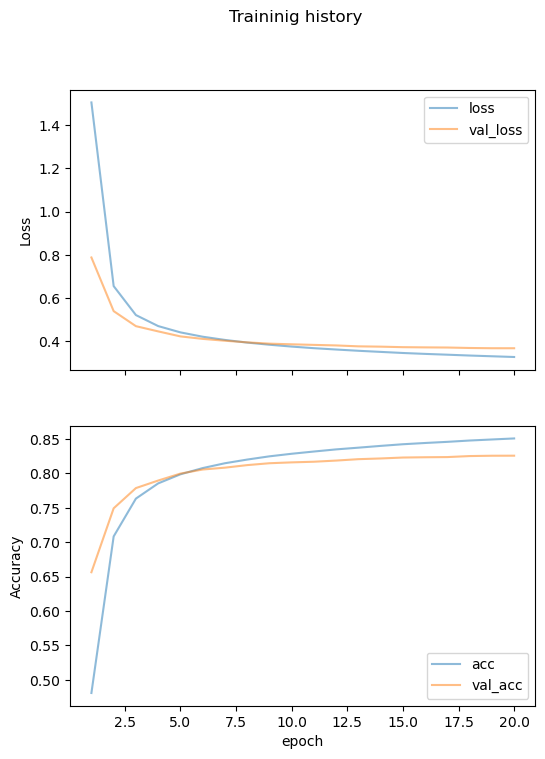

In [16]:
# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

plt.savefig("section10_figure01_model_accuract.jpg")

### Early stopping & checkpoint callback

Next, we can add early stopping and checkpoint callbacks. The *early stopping* callback can help interrupt the training when no progress is made. This implementation will stop the training when the validation loss stops improving after 5 epochs. The *checkpoint callback* can help you keep the best-score model rather than return only the final model at the last epoch.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss')

model = transformer(key_vals["num_layers"], key_vals["num_heads"], key_vals["seq_len"],
                    key_vals["key_dim"], key_vals["ff_dim"], key_vals["vocab_size_eng"],
                    key_vals["vocab_size_ita"], key_vals["dropout"])

lr = CustomSchedule(key_vals["key_dim"])
optimizer = tf.keras.optimizers.Adam(lr, optim_vals["beta_1"], optim_vals["beta_2"], optim_vals["epsilon"])
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stop, checkpoint])

model.save("ENG-ITA-transformer_fitted.h5")

Epoch 1/20
3920/3920 [==============================] - 16858s 4s/step - loss: 1.5072 - masked_accuracy: 0.4800 - val_loss: 0.7986 - val_masked_accuracy: 0.6470
Epoch 2/20
3920/3920 [==============================] - 6616s 2s/step - loss: 0.6615 - masked_accuracy: 0.7061 - val_loss: 0.5391 - val_masked_accuracy: 0.7489
Epoch 3/20
3920/3920 [==============================] - 9500s 2s/step - loss: 0.5220 - masked_accuracy: 0.7628 - val_loss: 0.4755 - val_masked_accuracy: 0.7779
Epoch 4/20
 949/3920 [======>.......................] - ETA: 1:21:18 - loss: 0.4831 - masked_accuracy: 0.7805